<h1 align="center">Custom Vision - Cognitive services Lab 2</h1>
<h1 align="center">Object Detection</h1>
<h1 align="center">Meetup DFW Data & AI - Microsoft</h1>
## Setting Up Environment

1. Go to https://customvision.ai/  and sign in with your azure account/ID
2. Once you are in, go to Settings (gear icon - upper right corner) and copy your Limited Trial Prediction and Training Key

In [ ]:
#This is only one time run to install the required python libraries on this virtual machine
!pip install azure-cognitiveservices-vision-customvision

## Initialize the libraries and origin and destination workspaces

In [1]:
from azure.cognitiveservices.vision.customvision.training import training_api
from azure.cognitiveservices.vision.customvision.training.models import ImageUrlCreateEntry, Region

# DESTINATION Resource Group Keys
dest_training_key = "<YOUR TRAINING KEY>"
dest_prediction_key = "<YOUR PREDICTION KEY>"
dest_project_new_name = "PowerItems_Detection_Copy"

# ORIGIN Resource Group Keys
training_key = "970bf90c200d4f429a233dee4239e8f1"
prediction_key = "23287e52d75349138403089743a504ab"

trainer = training_api.TrainingApi(training_key)
dest_trainer = training_api.TrainingApi(dest_training_key)

# Find the object detection domain
obj_detection_domain = next(domain for domain in trainer.get_domains() if domain.type == "ObjectDetection")
dest_obj_detection_domain = next(domain for domain in dest_trainer.get_domains() if domain.type == "ObjectDetection")

## Get the origin project ID reference

In [2]:
myProjects = trainer.get_projects()

In [3]:
for project in myProjects:
    print(project.name)
    print(project.id)
    print(project.description)

PowerItems_Detection
70e7718a-e1f1-45d5-bba1-60b224f55365
Model to detect Power line objects


In [4]:
Project = trainer.get_project(project_id="70e7718a-e1f1-45d5-bba1-60b224f55365")

## Create the destination Project 

In [5]:
dest_Project = dest_trainer.create_project(dest_project_new_name, domain_id=dest_obj_detection_domain.id)

In [6]:
for project in dest_trainer.get_projects():
    print(project.name)
    print(project.id)
    print(project.description)

PowerItems_Detection_Copy
af9d3130-d320-455d-a422-8aec060de876

PowerItems_Detection
70e7718a-e1f1-45d5-bba1-60b224f55365
Model to detect Power line objects


## Get the tags on origin project and create same tags on destination project

In [7]:
dest_tags = []
for tag in trainer.get_tags(Project.id):
    dest_tags.append(dest_trainer.create_tag(dest_Project.id, tag.name))
    print(tag.name)

crossarm
pole
insulator
switch
transformer


In [8]:
dest_tags_dict = {}
dest_tag_ids = []
for tag in dest_tags:
    dest_tags_dict[tag.name] = tag.id
    dest_tag_ids.append(tag.id)

print(dest_tags_dict)
print(dest_tag_ids)

{'pole': '5d0e90af-3076-4cd8-904d-701b84ebcdb0', 'switch': '08b2f01e-35e2-4259-a8ff-2f15cb7c3046', 'crossarm': '8db7aeba-e8f2-4f57-bbb1-83703470f348', 'transformer': '192ff805-108f-4c6e-ae68-29ddb9e59e80', 'insulator': '9e5b295a-11e9-4fb6-8bec-6957d8158b02'}
['8db7aeba-e8f2-4f57-bbb1-83703470f348', '5d0e90af-3076-4cd8-904d-701b84ebcdb0', '9e5b295a-11e9-4fb6-8bec-6957d8158b02', '08b2f01e-35e2-4259-a8ff-2f15cb7c3046', '192ff805-108f-4c6e-ae68-29ddb9e59e80']


## Get the images with regions on origin project

In [9]:
tagged_images = trainer.get_tagged_images(Project.id, take=trainer.get_tagged_image_count(Project.id))

In [10]:
tagged_images_with_regions = []
for image in tagged_images:
    dest_regions = []
    dest_tags_ids = []
    
    for tag in image.tags: #for each tag on the origin image
        dest_tags_ids.append(dest_tags_dict[tag.tag_name]) 
    for region in image.regions: #for each region on the origin image
        dest_regions.append(Region(tag_id=dest_tags_dict[region.tag_name], left=region.left, top=region.top, width=region.width, height=region.height))
    
    tagged_images_with_regions.append(ImageUrlCreateEntry(url=image.image_uri, tag_ids=dest_tags_ids, regions=dest_regions))
print("Done")

Done


## Create the images with regions on destination project

In [11]:
limit = 64 # this is a limit imposed on the API, so we need to batch the creation process
count_of_images = len(tagged_images_with_regions)

for i in range(0,count_of_images,limit):
    begin=i
    end=limit+i
    if(end > count_of_images ): end = count_of_images
    dest_trainer.create_images_from_urls(dest_Project.id, images=tagged_images_with_regions[begin:end])

In [12]:
print("Count of Tagged images on origin project: " + str(trainer.get_tagged_image_count(Project.id)))
print("Count of Tagged images on destination project: " + str(dest_trainer.get_tagged_image_count(dest_Project.id)))

Count of Tagged images on origin project: 220
Count of Tagged images on destination project: 220


## Train the model on destination Project

In [13]:
import time

print ("Training... (showing status each 10 seconds)")
iteration = dest_trainer.train_project(dest_Project.id)
while (iteration.status != "Completed"):
    iteration = dest_trainer.get_iteration(dest_Project.id, iteration.id)
    print ("Training status: " + iteration.status)
    time.sleep(10)

# The iteration is now trained. Make it the default project endpoint
dest_trainer.update_iteration(dest_Project.id, iteration.id, is_default=True)
print ("Done!")

Training... (showing status each 10 seconds)
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Training
Training status: Completed
Done!


## Get performance metrics

In [14]:
performance = dest_trainer.get_iteration_performance(dest_Project.id, iteration.id, threshold=0.15, overlap_threshold=0.30)
print("Iteration: " + iteration.name)
print("Precision: " + str(performance.precision * 100)+ "%")
print("Recall: " + str(performance.recall * 100) + "%")

Iteration: Iteration 1
Precision: 69.78417%
Recall: 44.2922384%


In [15]:
per_tag_performance = performance.per_tag_performance

In [16]:
for tag in per_tag_performance:
    print ("Tag: " + tag.name + "\t\t" + "Precision: " + str(tag.precision) + "\t" + "Recall: " + str(tag.recall))

Tag: insulator		Precision: 0.61403507	Recall: 0.333333343
Tag: switch		Precision: 0.5882353	Recall: 0.4
Tag: crossarm		Precision: 0.6666667	Recall: 0.4117647
Tag: pole		Precision: 0.8181818	Recall: 0.5625
Tag: transformer		Precision: 0.909090936	Recall: 0.8695652


## Get and use the default prediction endpoint

In [61]:
#You can make a web search online for "powerline pole" and get an URL image example like this:
url = "https://cnx.org/resources/0dda2e5d58aedea82e70669236f6503c938f58a4/CNX_UPhysics_32_06_Twork.jpg"

<div style="width:100%; margin-left:auto; margin-right:auto; margin-bottom:5px; margin-top:17px;">
<img src="https://cnx.org/resources/0dda2e5d58aedea82e70669236f6503c938f58a4/CNX_UPhysics_32_06_Twork.jpg" alt="IMAGE" /><br>

</div>

In [55]:
from azure.cognitiveservices.vision.customvision.prediction import prediction_endpoint
from azure.cognitiveservices.vision.customvision.prediction.prediction_endpoint import models

# Now there is a trained endpoint that can be used to make a prediction
dest_predictor = prediction_endpoint.PredictionEndpoint(dest_prediction_key)

# Open the sample image and get back the prediction results.
results = dest_predictor.predict_image_url(dest_Project.id, iteration_id=iteration.id, url=url)

	crossarm: 53.35%    Box relative points: 0.02304019 0.04299379 0.4607492 0.219520032
	insulator: 31.71%    Box relative points: 0.0505172275 0.04642609 0.08673376 0.0692497641
	insulator: 28.83%    Box relative points: 0.422706 0.031383425 0.0597718656 0.066601485
	switch: 29.83%    Box relative points: 0.0607942455 0.120907322 0.08338027 0.114170507
	switch: 50.70%    Box relative points: 0.7089651 0.258346915 0.0721645355 0.09107077
	transformer: 79.21%    Box relative points: 0.261969477 0.471701145 0.211385638 0.287572861
	transformer: 54.88%    Box relative points: 0.5631212 0.479028583 0.22144419 0.261688828


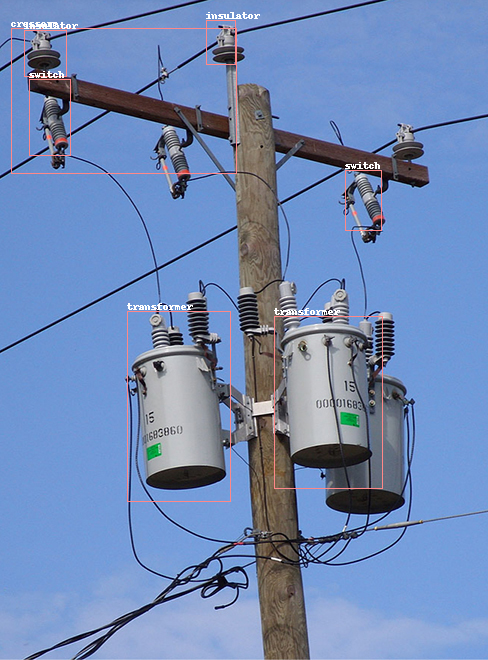

In [60]:
from PIL import Image, ImageDraw
from urllib.request import urlopen
import io
from IPython.display import display

file = urlopen(url)
image_file = io.BytesIO(file.read())
im = Image.open(image_file)
x,y = im.size
draw = ImageDraw.Draw(im)

# Display the results.
for prediction in results.predictions:
    if(prediction.probability > 0.25): # only show the prediction with more than 25% threshold probability
        print ("\t" + prediction.tag_name + ": {0:.2f}%".format(prediction.probability * 100), "   Box relative points:",prediction.bounding_box.left, prediction.bounding_box.top, prediction.bounding_box.width, prediction.bounding_box.height)
        x0 = x * prediction.bounding_box.left
        y0 = y * prediction.bounding_box.top
        x1 = x0 + x * prediction.bounding_box.width
        y1 = y0 + y * prediction.bounding_box.height
        draw.rectangle(((x0 , y0 ), (x1 , y1)), outline="#ff8888")
        draw.text((x0, y0-10), prediction.tag_name)

display(im)